In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib as plt
import lightgbm as lgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_validate
from sklearn.inspection import permutation_importance
import numpy as np

In [2]:
df_gas = pd.read_csv(f'{os.path.expanduser("~")}\\IconPro GmbH\\IconPro GmbH - Dokumente\\40 Projects\\035 Talos\\Client data\\Brampton\\Gas\\Master\\agg_gas_table.csv')
df_elec = pd.read_csv(f'{os.path.expanduser("~")}\\IconPro GmbH\\IconPro GmbH - Dokumente\\40 Projects\\035 Talos\\Client data\\Brampton\\Elec\\Master\\all_elec_table.csv')

In [3]:
df_elec['time'] = pd.to_datetime(df_elec['time'])
df_elec['time'] -= pd.to_timedelta(2, unit='h')
df_elec['date'] = pd.to_datetime(pd.to_datetime(df_elec['time']).dt.date)
df_gas['date'] = pd.to_datetime(df_gas['date'])
df_gas.set_index('date', inplace=True)
df_elec = df_elec[df_elec['Measure'].str.contains('Feeder')]
df_elec_agg = df_elec.groupby(['date']).agg({'Data Point':'sum'})
df = df_gas.join(df_elec_agg[['Data Point']], how='left')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
# day of week to one hot encoding
df = pd.concat([df, pd.get_dummies(df['day_of_week'], prefix='day')], axis=1)
# create dummies for clusters
df = pd.concat([df, pd.get_dummies(df['cluster'], prefix='cluster')], axis=1)

In [5]:
df.rename(columns={'Data Point': 'elec_con'}, inplace=True)
df.replace({True: 1, False: 0}, inplace=True)
df.dropna(inplace=True)

In [6]:
fs = [
    'elec_con',
    'day',
    'production',
    'last_day_production',
    'last_day_consumption',
    'mean_temp',
    'heating_degree_hours',
    'cluster',
    'morning_temp',
    'evening_temp',
    'afternoon_temp'
]
X = df[fs]
y = df['consumption']

In [7]:
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
regr = AdaBoostRegressor(n_estimators=100)
regr.fit(X_train, y_train)

AdaBoostRegressor(n_estimators=100)

In [8]:
# Use sequential feature selection
from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(regr, n_features_to_select=8, direction='forward', cv=10)
sfs.fit(X, y)

SequentialFeatureSelector(cv=10, estimator=AdaBoostRegressor(n_estimators=100),
                          n_features_to_select=8)

In [9]:
X, y = df[X.columns[sfs.get_support()]], df['consumption']
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
regr = AdaBoostRegressor()
scores = cross_validate(regr, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics1 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['adb'])
metrics1

,r2,mae,rmse,mape
adb,0.915057,13589.105733,17430.898486,0.781926


In [10]:
regr = LinearRegression()
scores = cross_validate(regr, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics2 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['lr'])
metrics2

,r2,mae,rmse,mape
lr,0.903495,14222.117134,18592.883704,0.483889


<AxesSubplot:xlabel='consumption', ylabel='consumption'>

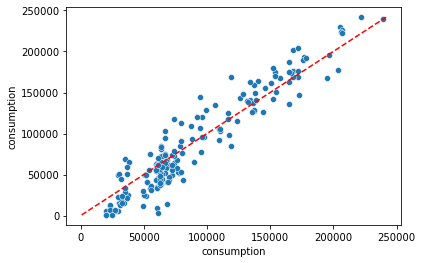

In [11]:
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
regr = AdaBoostRegressor(n_estimators=100)
regr.fit(X_train, y_train)

# Predict
prediction = regr.predict(X_test)

# Plot
sns.scatterplot(x=prediction, y=y_test)
# Plot a diagonal dotted line
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')

In [12]:
# selected features
fs = X.columns.values

In [13]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.05, random_state=42)
df['outliers'] = clf.fit_predict(np.array(X))

In [14]:
X, y = df[df['outliers']==1][fs], df[df['outliers']==1]['consumption']
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
regr = AdaBoostRegressor()
scores = cross_validate(regr, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics3 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['adb_ifr'])
metrics3

,r2,mae,rmse,mape
adb_ifr,0.916348,13260.62306,16901.149543,0.781623


In [15]:
X, y = df[df['outliers']==1][fs], df[df['outliers']==1]['consumption']
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
regr = LinearRegression()
scores = cross_validate(regr, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics4 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['lr_ifr'])
metrics4

,r2,mae,rmse,mape
lr_ifr,0.919186,12739.984364,16619.302413,0.482396


In [16]:
pd.concat([metrics1, metrics2, metrics3, metrics4])

,r2,mae,rmse,mape
adb,0.915057,13589.105733,17430.898486,0.781926
lr,0.903495,14222.117134,18592.883704,0.483889
adb_ifr,0.916348,13260.623060,16901.149543,0.781623
lr_ifr,0.919186,12739.984364,16619.302413,0.482396


<AxesSubplot:xlabel='consumption', ylabel='consumption'>

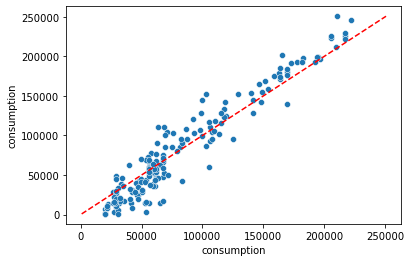

In [17]:
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
regr = AdaBoostRegressor(n_estimators=100)
regr.fit(X_train, y_train)

# Predict
prediction = regr.predict(X_test)

# Plot
sns.scatterplot(x=prediction, y=y_test)
# Plot a diagonal dotted line
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')

In [18]:
dfgb = pd.read_csv('C:\\Users\\hahoa\\Downloads\\iconpro_talos\\features_for_autoML.csv')
fs = ['mean_temp', 'heating_degree_hours',
       'day', 'week', 'day_of_week', 'production', 'morning_temp',
       'afternoon_temp', 'evening_temp', 'mean_temp_prev_1',
       'morning_temp_prev_1', 'afternoon_temp_prev_1', 'evening_temp_prev_1',
       'heating_degree_hours_prev_1', 'mean_temp_prev_2',
       'morning_temp_prev_2', 'afternoon_temp_prev_2', 'evening_temp_prev_2',
       'heating_degree_hours_prev_2', 'mean_temp_prev_3',
       'morning_temp_prev_3', 'afternoon_temp_prev_3', 'evening_temp_prev_3',
       'heating_degree_hours_prev_3', 'last_day_production',
       'last_day_consumption', 'cluster', 'elec_con', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'cluster_0.0',
       'cluster_1.0', 'cluster_2.0', 'cluster_3.0', 'cluster_4.0',
       'cluster_5.0', 'cluster_6.0', 'cluster_7.0']

In [19]:
X = df[fs]
y = df['consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [20]:
gbre = GradientBoostingRegressor(random_state=0)
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=12)
regr = LinearRegression()
scores = cross_validate(gbre, X, y, cv=rkf, scoring=('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error', 
                                               'neg_mean_absolute_percentage_error'))
metrics5 = pd.DataFrame({'r2':[scores['test_r2'].mean()], 'mae':[-1*scores['test_neg_mean_absolute_error'].mean()], 
          'rmse':[-1*scores['test_neg_root_mean_squared_error'].mean()],
          'mape':[-1*scores['test_neg_mean_absolute_percentage_error'].mean()]}, index=['gb'])
metrics5

,r2,mae,rmse,mape
gb,0.960023,8179.388374,11940.757417,0.314125


<AxesSubplot:xlabel='consumption', ylabel='consumption'>

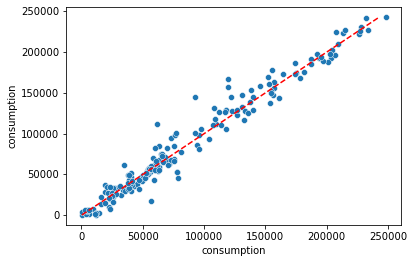

In [21]:
# Split the data into training/testing sets 80/20 percent and shuffle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Initialize and fit the model.
gbre = GradientBoostingRegressor()
gbre.fit(X_train, y_train)

# Predict
prediction = gbre.predict(X_test)

# Plot
sns.scatterplot(x=prediction, y=y_test)
# Plot a diagonal dotted line
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')

In [22]:
r = permutation_importance(gbre, X_test, y_test, n_repeats=30, random_state=0)

In [23]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{fs[i]:<8}, {r.importances_mean[i]:.3f}, +/- {r.importances_std[i]:.3f}")

last_day_consumption, 0.503, +/- 0.044
evening_temp, 0.354, +/- 0.029
elec_con, 0.215, +/- 0.026
cluster , 0.017, +/- 0.003
cluster_2.0, 0.008, +/- 0.001
production, 0.008, +/- 0.002
last_day_production, 0.006, +/- 0.001
day     , 0.005, +/- 0.001
day_of_week, 0.004, +/- 0.001
day_6   , 0.003, +/- 0.001
morning_temp, 0.002, +/- 0.001
morning_temp_prev_3, 0.002, +/- 0.001
afternoon_temp, 0.002, +/- 0.000
day_5   , 0.001, +/- 0.001
day_4   , 0.001, +/- 0.000
cluster_1.0, 0.001, +/- 0.000
cluster_7.0, 0.001, +/- 0.001
cluster_4.0, 0.001, +/- 0.001
afternoon_temp_prev_3, 0.001, +/- 0.000
week    , 0.001, +/- 0.001
day_0   , 0.001, +/- 0.000
heating_degree_hours_prev_1, 0.000, +/- 0.000
heating_degree_hours_prev_3, 0.000, +/- 0.000
mean_temp_prev_1, 0.000, +/- 0.000
mean_temp, 0.000, +/- 0.000
mean_temp_prev_3, 0.000, +/- 0.000
cluster_3.0, 0.000, +/- 0.000
evening_temp_prev_1, 0.000, +/- 0.000
afternoon_temp_prev_1, 0.000, +/- 0.000
morning_temp_prev_2, 0.000, +/- 0.000
cluster_0.0, 0.000,

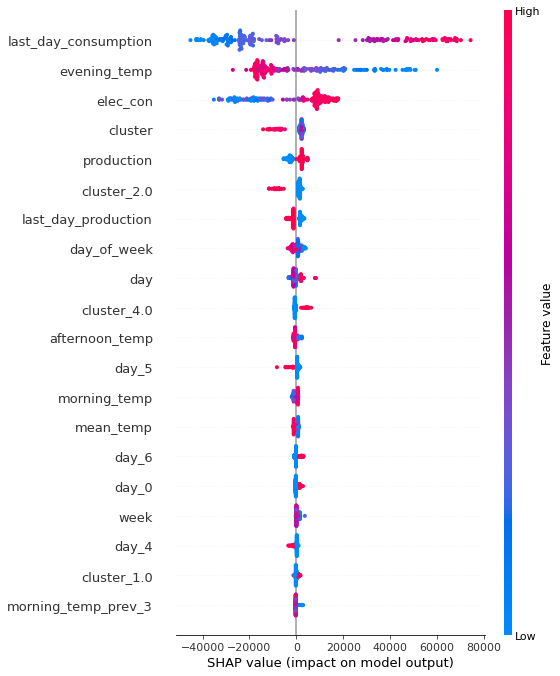

In [24]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbre)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

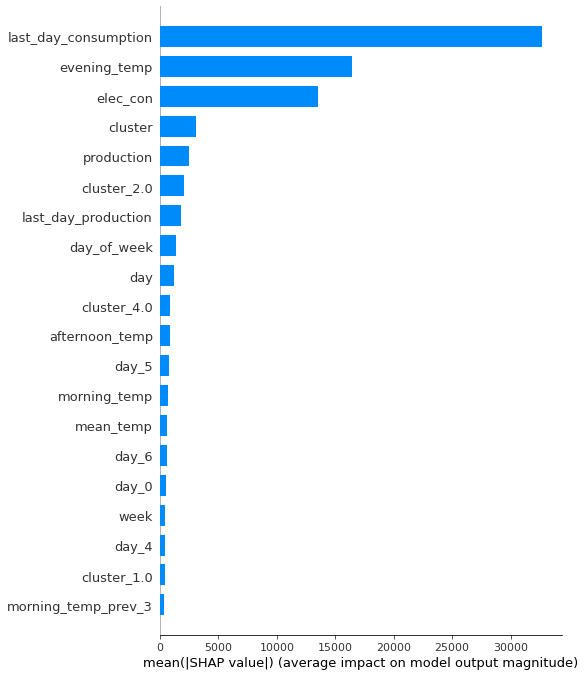

In [25]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [26]:
# https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html
#!pip install lightgbm
# https://www.kaggle.com/code/lasmith/house-price-regression-with-lightgbm

# defining parameters 
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l1','l2'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000
}

In [27]:
gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's l1: 32409.4	valid_0's l2: 1.50616e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's l1: 32280	valid_0's l2: 1.49464e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's l1: 32151.2	valid_0's l2: 1.48324e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	valid_0's l1: 32023	valid_0's l2: 1.47195e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's l1: 31895.5	valid_0's l2: 1.46077e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[117]	valid_0's l1: 31766.5	valid_0's l2: 1.44959e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[118]	valid_0's l1: 31639.8	valid_0's l2: 1.43866e+09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[119]	valid_0's l1: 31511.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's l1: 17246.2	valid_0's l2: 4.78022e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's l1: 17191.4	valid_0's l2: 4.75453e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	valid_0's l1: 17136.6	valid_0's l2: 4.72895e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	valid_0's l1: 17080.8	valid_0's l2: 4.7028e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	valid_0's l1: 17026.5	valid_0's l2: 4.67772e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	valid_0's l1: 16971	valid_0's l2: 4.65302e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	valid_0's l1: 16916.7	valid_0's l2: 4.62823e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	valid_0's l1: 16864

[466]	valid_0's l1: 10970.2	valid_0's l2: 2.3131e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[467]	valid_0's l1: 10955.3	valid_0's l2: 2.30802e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[468]	valid_0's l1: 10940.9	valid_0's l2: 2.30321e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[469]	valid_0's l1: 10923.2	valid_0's l2: 2.29767e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[470]	valid_0's l1: 10904.7	valid_0's l2: 2.29194e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[471]	valid_0's l1: 10885	valid_0's l2: 2.28529e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[472]	valid_0's l1: 10865.1	valid_0's l2: 2.27911e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[473]	valid_0's l1: 10851.8	valid_0's l2: 2.27429e+08
[LightGBM] [Warning] No further splits with po

[638]	valid_0's l1: 8937.94	valid_0's l2: 1.69464e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[639]	valid_0's l1: 8929.04	valid_0's l2: 1.69213e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[640]	valid_0's l1: 8920.02	valid_0's l2: 1.68964e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[641]	valid_0's l1: 8914.31	valid_0's l2: 1.68788e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[642]	valid_0's l1: 8908.62	valid_0's l2: 1.68614e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's l1: 8901.48	valid_0's l2: 1.68411e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[644]	valid_0's l1: 8896.81	valid_0's l2: 1.68242e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[645]	valid_0's l1: 8891.33	valid_0's l2: 1.68075e+08
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[801]	valid_0's l1: 8157.63	valid_0's l2: 1.46028e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[802]	valid_0's l1: 8151.59	valid_0's l2: 1.45888e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[803]	valid_0's l1: 8145.84	valid_0's l2: 1.45741e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[804]	valid_0's l1: 8139.93	valid_0's l2: 1.45577e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[805]	valid_0's l1: 8134.36	valid_0's l2: 1.45426e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[806]	valid_0's l1: 8129.24	valid_0's l2: 1.45278e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[807]	valid_0's l1: 8122.96	valid_0's l2: 1.45134e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[808]	valid_0's l1: 81

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[979]	valid_0's l1: 7780.29	valid_0's l2: 1.36033e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[980]	valid_0's l1: 7780.2	valid_0's l2: 1.36021e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[981]	valid_0's l1: 7778.42	valid_0's l2: 1.35971e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[982]	valid_0's l1: 7776.64	valid_0's l2: 1.35922e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[983]	valid_0's l1: 7775.08	valid_0's l2: 1.35891e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[984]	valid_0's l1: 7773.32	valid_0's l2: 1.35842e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[985]	valid_0's l1: 7772.3	valid_0's l2: 1.35807e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[986]	valid_0's l1: 7770

[1149]	valid_0's l1: 7615.43	valid_0's l2: 1.31209e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1150]	valid_0's l1: 7616.34	valid_0's l2: 1.31225e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1151]	valid_0's l1: 7615.71	valid_0's l2: 1.31198e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1152]	valid_0's l1: 7613.79	valid_0's l2: 1.31127e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1153]	valid_0's l1: 7611.88	valid_0's l2: 1.31052e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1154]	valid_0's l1: 7611.29	valid_0's l2: 1.31023e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1155]	valid_0's l1: 7609.38	valid_0's l2: 1.3095e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1156]	valid_0's l1: 7607.67	valid_0's l2: 1.30879e+08
[LightGBM] [Warning] No further spli

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1322]	valid_0's l1: 7503.28	valid_0's l2: 1.27694e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1323]	valid_0's l1: 7501.73	valid_0's l2: 1.27661e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1324]	valid_0's l1: 7501.27	valid_0's l2: 1.27643e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's l1: 7499.73	valid_0's l2: 1.27611e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1326]	valid_0's l1: 7500.08	valid_0's l2: 1.276e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1327]	valid_0's l1: 7499.51	valid_0's l2: 1.27585e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1328]	valid_0's l1: 7499.25	valid_0's l2: 1.27579e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1329]	valid_0's 

[1476]	valid_0's l1: 7406.16	valid_0's l2: 1.24878e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1477]	valid_0's l1: 7406.5	valid_0's l2: 1.2486e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1478]	valid_0's l1: 7406.7	valid_0's l2: 1.24848e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1479]	valid_0's l1: 7406.39	valid_0's l2: 1.24835e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1480]	valid_0's l1: 7405.89	valid_0's l2: 1.248e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1481]	valid_0's l1: 7405.21	valid_0's l2: 1.24778e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1482]	valid_0's l1: 7405.22	valid_0's l2: 1.24764e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1483]	valid_0's l1: 7405.24	valid_0's l2: 1.24751e+08
[LightGBM] [Warning] No further splits w

[1648]	valid_0's l1: 7374.65	valid_0's l2: 1.22675e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1649]	valid_0's l1: 7374.57	valid_0's l2: 1.22641e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1650]	valid_0's l1: 7374.77	valid_0's l2: 1.22606e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1651]	valid_0's l1: 7374.71	valid_0's l2: 1.22598e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1652]	valid_0's l1: 7374.58	valid_0's l2: 1.22578e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1653]	valid_0's l1: 7374.47	valid_0's l2: 1.22571e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1654]	valid_0's l1: 7374.41	valid_0's l2: 1.22564e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1655]	valid_0's l1: 7374.56	valid_0's l2: 1.22577e+08
[LightGBM] [Warning] No further spl

[1818]	valid_0's l1: 7391.44	valid_0's l2: 1.21867e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1819]	valid_0's l1: 7391.41	valid_0's l2: 1.21861e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1820]	valid_0's l1: 7391.51	valid_0's l2: 1.21879e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1821]	valid_0's l1: 7391.38	valid_0's l2: 1.21887e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1822]	valid_0's l1: 7390.77	valid_0's l2: 1.21882e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1823]	valid_0's l1: 7390.64	valid_0's l2: 1.2189e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1824]	valid_0's l1: 7389.33	valid_0's l2: 1.2186e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1825]	valid_0's l1: 7389.22	valid_0's l2: 1.21861e+08
[LightGBM] [Warning] No further split

[1962]	valid_0's l1: 7350.63	valid_0's l2: 1.20674e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1963]	valid_0's l1: 7350.57	valid_0's l2: 1.20659e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1964]	valid_0's l1: 7350.47	valid_0's l2: 1.20647e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1965]	valid_0's l1: 7350.27	valid_0's l2: 1.20631e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1966]	valid_0's l1: 7350.29	valid_0's l2: 1.20626e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1967]	valid_0's l1: 7350.47	valid_0's l2: 1.20627e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1968]	valid_0's l1: 7350.75	valid_0's l2: 1.20622e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1969]	valid_0's l1: 7350.46	valid_0's l2: 1.20605e+08
[LightGBM] [Warning] No further spl

[2130]	valid_0's l1: 7335.6	valid_0's l2: 1.19922e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2131]	valid_0's l1: 7336.08	valid_0's l2: 1.19919e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2132]	valid_0's l1: 7336.77	valid_0's l2: 1.19922e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2133]	valid_0's l1: 7337.3	valid_0's l2: 1.19923e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2134]	valid_0's l1: 7337.62	valid_0's l2: 1.19918e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2135]	valid_0's l1: 7338.13	valid_0's l2: 1.19922e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2136]	valid_0's l1: 7338.82	valid_0's l2: 1.19925e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2137]	valid_0's l1: 7339.34	valid_0's l2: 1.19927e+08
[LightGBM] [Warning] No further split

[2302]	valid_0's l1: 7350.02	valid_0's l2: 1.19447e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2303]	valid_0's l1: 7349.05	valid_0's l2: 1.19428e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2304]	valid_0's l1: 7348.98	valid_0's l2: 1.19432e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2305]	valid_0's l1: 7348.82	valid_0's l2: 1.19433e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2306]	valid_0's l1: 7348.75	valid_0's l2: 1.19437e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2307]	valid_0's l1: 7348.42	valid_0's l2: 1.19431e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2308]	valid_0's l1: 7347.58	valid_0's l2: 1.19403e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2309]	valid_0's l1: 7347.52	valid_0's l2: 1.19408e+08
[LightGBM] [Warning] No further spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2470]	valid_0's l1: 7364.29	valid_0's l2: 1.19668e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2471]	valid_0's l1: 7364.26	valid_0's l2: 1.19673e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2472]	valid_0's l1: 7364.25	valid_0's l2: 1.19678e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2473]	valid_0's l1: 7364.39	valid_0's l2: 1.19679e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2474]	valid_0's l1: 7364.44	valid_0's l2: 1.19684e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2475]	valid_0's l1: 7364.61	valid_0's l2: 1.19685e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2476]	valid_0's l1: 7364.81	valid_0's l2: 1.19685e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2477]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2608]	valid_0's l1: 7343.62	valid_0's l2: 1.18775e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2609]	valid_0's l1: 7343.06	valid_0's l2: 1.18754e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2610]	valid_0's l1: 7342.64	valid_0's l2: 1.18732e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2611]	valid_0's l1: 7342.15	valid_0's l2: 1.18733e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2612]	valid_0's l1: 7341.13	valid_0's l2: 1.18726e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2613]	valid_0's l1: 7340.59	valid_0's l2: 1.1872e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2614]	valid_0's l1: 7340	valid_0's l2: 1.18717e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2615]	valid_0's l1

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2779]	valid_0's l1: 7352.73	valid_0's l2: 1.18496e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2780]	valid_0's l1: 7353.23	valid_0's l2: 1.18522e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2781]	valid_0's l1: 7352.94	valid_0's l2: 1.18502e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2782]	valid_0's l1: 7352.69	valid_0's l2: 1.18501e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2783]	valid_0's l1: 7352.63	valid_0's l2: 1.18484e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2784]	valid_0's l1: 7352.34	valid_0's l2: 1.18463e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2785]	valid_0's l1: 7352.13	valid_0's l2: 1.18462e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2786]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2955]	valid_0's l1: 7358.06	valid_0's l2: 1.18095e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2956]	valid_0's l1: 7358.41	valid_0's l2: 1.18102e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2957]	valid_0's l1: 7358.88	valid_0's l2: 1.18115e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2958]	valid_0's l1: 7358.8	valid_0's l2: 1.18113e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2959]	valid_0's l1: 7358.62	valid_0's l2: 1.18108e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2960]	valid_0's l1: 7358.79	valid_0's l2: 1.18107e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2961]	valid_0's l1: 7359.02	valid_0's l2: 1.181e+08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2962]	valid_0's l

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l1', 'l2'], num_iterations=100000, num_leaves=128,
              objective='regression', task='train', verbose=0)

In [28]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(y_pred, y_train) ** 0.5, 5))

The rmse of prediction is: 4982.0375


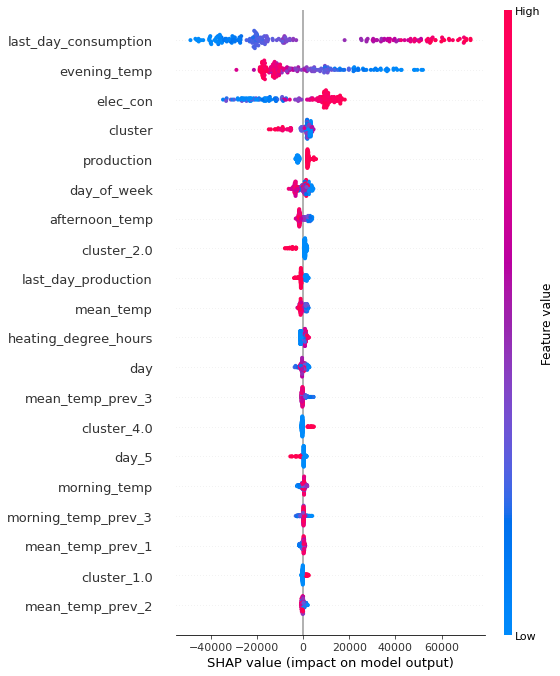

In [29]:
# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_importance)
# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

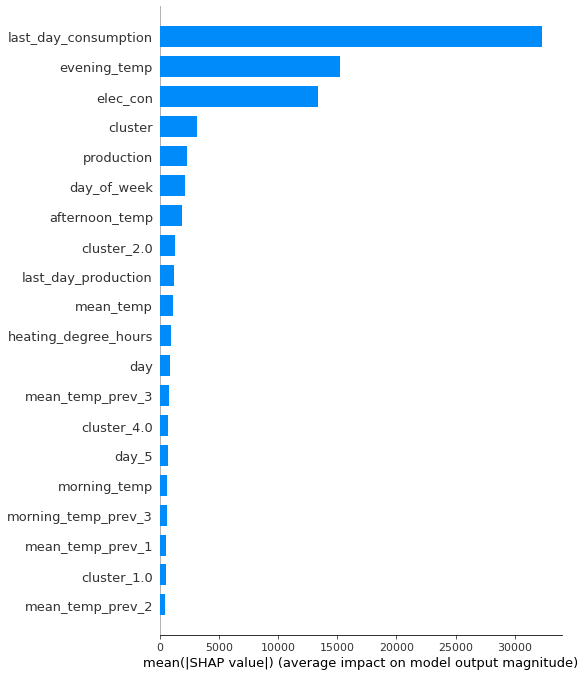

In [30]:
# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')